In [1]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame,date_range
from matplotlib import cm
import seaborn as sns
import scipy as sp
import math
import warnings
from scipy.stats import poisson

warnings.filterwarnings('ignore')
import sys
sys.setrecursionlimit(10001)
print(sys.getrecursionlimit())


10001


In [2]:
### single run
# start
# single colony, death happens right away
# complex model regenerate at diff time and infect at diff time, time_step = 0.1
# fixed parameter
Max_cell_density = 1e10
Pim = 0 #Proportion of cells already immune

def currentPim(initialPhagePerCell,Pns,K1,K2,initialCellsPerMl,uninfectedCellsPerMl,immuneCellsPerMl=0,numPhagesPerMl = 0, y = 0):
    if y == 0:
        numPhagesPerMl = initialCellsPerMl*initialPhagePerCell
    # infection 
    expectedNumCellInfected = K1*numPhagesPerMl*uninfectedCellsPerMl
    numCellInfected = min(expectedNumCellInfected,uninfectedCellsPerMl,numPhagesPerMl)
    immuneCellsPerMl += Pns*numCellInfected 
    # then regenerate
    numPhagesPerMl += max(K2*numCellInfected,0)
    uninfectedCellsPerMl += -numCellInfected 
    uninfectedCellsPerMl += celldoubling_per_time_step*uninfectedCellsPerMl
    immuneCellsPerMl += celldoubling_per_time_step*immuneCellsPerMl
    total_cell = (uninfectedCellsPerMl + immuneCellsPerMl)
    if total_cell > Max_cell_density:
        # reach max cell density
        dilution_fold = total_cell/Max_cell_density
        immuneCellsPerMl = immuneCellsPerMl/dilution_fold
        uninfectedCellsPerMl = uninfectedCellsPerMl/dilution_fold
    y += time_step
    # eat, dilution
    if int(y/eating_time) != int((y - time_step)/eating_time):
        dilution_fold = (immuneCellsPerMl+uninfectedCellsPerMl)/initialCellsPerMl
        #print('eat',y)
        if dilution_fold > 1:
            immuneCellsPerMl = immuneCellsPerMl/dilution_fold
            uninfectedCellsPerMl = uninfectedCellsPerMl/dilution_fold
            numPhagesPerMl = numPhagesPerMl/dilution_fold
    Pim = immuneCellsPerMl/(immuneCellsPerMl + uninfectedCellsPerMl)
    if uninfectedCellsPerMl == 0:
        return y
    elif Pim >= detection_limit:
        return y
    elif y>=y_max:
        return y
    else:
        try:
            return currentPim(initialPhagePerCell,Pns,K1,K2,initialCellsPerMl,uninfectedCellsPerMl,immuneCellsPerMl,numPhagesPerMl, y)
        except RecursionError:
            return y_max



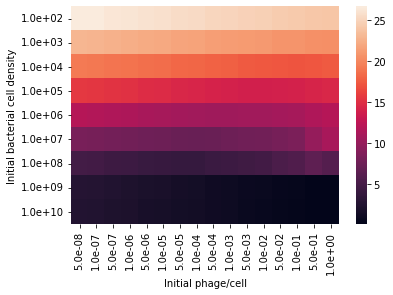

In [3]:
allchangingparameters = {
    'Pnsset':[1e-2,1e-4,1e-6,1e-8,1e-10],
    'detection_limitset':[0.1,0.2,0.5,0.9],
    'time_stepset':[0.01,0.1,0.2,0.5,1],
    'generation_timeset':[0.1,1,2,5,10],
    'K1set' : [np.power(0.1,x) for x in range(1,25)],
    'K2set' : [0.01,0.1,0.5,1,5,10,100,1000],
    'initialCellsPerMlset' :[1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9,1e10],
    'eating_timeset':[5,4,3,2,1,0.5,0.33,0.25,0.1],# * generation_time
    'phagePerCellset' : [x/20000000 for x in range(1,3)]+[x/2000000 for x in range(1,3)]+[x/200000 for x in range(1,3)]+[x/20000 for x in range(1,3)]+[x/2000 for x in range(1,3)]+[x/200 for x in range(1,3)]+[x/20 for x in range(1,3)]+[x/2 for x in range(1,3)]
}

# parameters
phagePerCell = 1e-3
Pns = 1e-8*(1 + 1e-1 + 1e-2 + 1e-3 + 1e-4 + 1e-5) # Exploitation of the Cooperative Behaviors of Anti-CRISPR Phages, cfu per ml = 1e8, read frequency of additional spacers decrease by 1/10
detection_limit = 0.1
time_step = 0.1
generation_time = 1 # 1 day
K1 = 1e-9 # absorption rate, 1e-10 to 1e−9 phage−1 cell−1 ml−1 min−1 for 24h
K2 = 1 #effective phage burst size, [https://www.frontiersin.org/articles/10.3389/fcimb.2021.643214/full CrAssphage 2.5] usually 10-100
initialCellsPerMl = 1e8 # cells per ml of the species of interest
eating_time = 1001# no eat
celldoubling_per_time_step = np.power(2,time_step) - 1

# others
y_max = 1000*generation_time
df = pd.DataFrame(columns=allchangingparameters['phagePerCellset'],index = allchangingparameters['initialCellsPerMlset'])
for initialCellsPerMl in df.index:
    for phagePerCell in df.columns:
        eating_time = eating_time*generation_time
        df.loc[initialCellsPerMl,phagePerCell] = currentPim(phagePerCell,Pns,K1,K2,initialCellsPerMl,initialCellsPerMl)

df.columns = ['%.1e'%i for i in df.columns]
df.index = ['%.1e'%i for i in df.index]
df = df.astype(float)
sns.heatmap(data=df)
plt.xlabel('Initial phage/cell')  
plt.ylabel('Initial bacterial cell density') 
plt.savefig('data/model/Nodilution_phagedensityVSbacterialdensity.pdf', bbox_inches='tight')



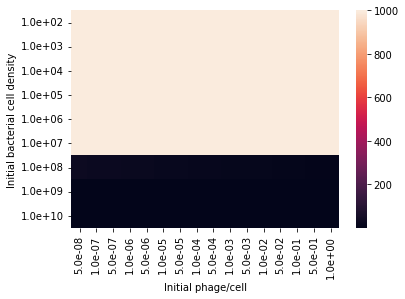

In [12]:
allchangingparameters = {
    'Pnsset':[1e-2,1e-4,1e-6,1e-8,1e-10],
    'detection_limitset':[0.1,0.2,0.5,0.9],
    'time_stepset':[0.01,0.1,0.2,0.5,1],
    'generation_timeset':[0.1,1,2,5,10],
    'K1set' : [np.power(0.1,x) for x in range(1,25)],
    'K2set' : [0.01,0.1,0.5,1,5,10,100,1000],
    'initialCellsPerMlset' :[1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9,1e10],
    'eating_timeset':[5,4,3,2,1,0.5,0.33,0.25,0.1],# * generation_time
    'phagePerCellset' : [x/20000000 for x in range(1,3)]+[x/2000000 for x in range(1,3)]+[x/200000 for x in range(1,3)]+[x/20000 for x in range(1,3)]+[x/2000 for x in range(1,3)]+[x/200 for x in range(1,3)]+[x/20 for x in range(1,3)]+[x/2 for x in range(1,3)]
}

# parameters
phagePerCell = 1e-3
Pns = 1e-8*(1 + 1e-1 + 1e-2 + 1e-3 + 1e-4 + 1e-5) # Exploitation of the Cooperative Behaviors of Anti-CRISPR Phages, cfu per ml = 1e8, read frequency of additional spacers decrease by 1/10
detection_limit = 0.1
time_step = 0.1
generation_time = 1 # 1 day
K1 = 1e-9 # absorption rate, 1e-10 to 1e−9 phage−1 cell−1 ml−1 min−1 for 24h
K2 = 1 #effective phage burst size, [https://www.frontiersin.org/articles/10.3389/fcimb.2021.643214/full CrAssphage 2.5] usually 10-100
initialCellsPerMl = 1e8 # cells per ml of the species of interest
eating_time = 1# 1 per generation
celldoubling_per_time_step = np.power(2,time_step) - 1

# others
y_max = 1000*generation_time
df = pd.DataFrame(columns=allchangingparameters['phagePerCellset'],index = allchangingparameters['initialCellsPerMlset'])
for initialCellsPerMl in df.index:
    for phagePerCell in df.columns:
        eating_time = eating_time*generation_time
        df.loc[initialCellsPerMl,phagePerCell] = currentPim(phagePerCell,Pns,K1,K2,initialCellsPerMl,initialCellsPerMl)

df.columns = ['%.1e'%i for i in df.columns]
df.index = ['%.1e'%i for i in df.index]
df = df.astype(float)
sns.heatmap(data=df)
plt.xlabel('Initial phage/cell')  
plt.ylabel('Initial bacterial cell density') 
plt.savefig('data/model/Dilution_phagedensityVSbacterialdensity.pdf', bbox_inches='tight')



In [21]:
allchangingparameters = {
    'Pnsset':[1e-2,1e-4,1e-6,1e-8,1e-10],
    'detection_limitset':[0.1,0.2,0.5,0.9],
    'time_stepset':[0.01,0.1,0.2,0.5,1],
    'generation_timeset':[0.1,1,2,5,10],
    'K1set' : [np.power(0.1,x) for x in range(1,25)],
    'K2set' : [0.01,0.1,0.5,1,5,10,100,1000],
    'initialCellsPerMlset' :[1e10,1e9,1e8,1e7,1e6,1e5,1e4,1e3,1e2],
    'eating_timeset':[1000,100,50,30,25,20,15,10,5,4,1,0.1,0.01],# * generation_time
    'phagePerCellset' : [x/20000000 for x in range(1,3)]+[x/2000000 for x in range(1,3)]+[x/200000 for x in range(1,3)]+[x/20000 for x in range(1,3)]+[x/2000 for x in range(1,3)]+[x/200 for x in range(1,3)]+[x/20 for x in range(1,3)]+[x/2 for x in range(1,3)]
}

# parameters
phagePerCell = 1e-3
Pns = 1e-8*(1 + 1e-1 + 1e-2 + 1e-3 + 1e-4 + 1e-5) # Exploitation of the Cooperative Behaviors of Anti-CRISPR Phages, cfu per ml = 1e8, read frequency of additional spacers decrease by 1/10
detection_limit = 0.1
time_step = 0.1
generation_time = 1 # 1 day
K1 = 1e-9 # absorption rate, 1e-10 to 1e−9 phage−1 cell−1 ml−1 min−1 for 24h
K2 = 1 #effective phage burst size, [https://www.frontiersin.org/articles/10.3389/fcimb.2021.643214/full CrAssphage 2.5] usually 10-100
initialCellsPerMl = 1e8 # cells per ml of the species of interest
eating_time = 1000# no eat
celldoubling_per_time_step = np.power(2,time_step) - 1

# others
y_max = 1000*generation_time
df = pd.DataFrame(columns=allchangingparameters['eating_timeset'],
                  index = allchangingparameters['initialCellsPerMlset'],data= 0,dtype = float)
for initialCellsPerMl in df.index:
    for eating_time in df.columns:
        eating_time = eating_time*generation_time
        sweeping_time = currentPim(phagePerCell,Pns,K1,K2,initialCellsPerMl,initialCellsPerMl)
        df.loc[initialCellsPerMl,eating_time] = sweeping_time

df.columns = ['%.1e'%i for i in df.columns]
df.index = ['%.1e'%i for i in df.index]


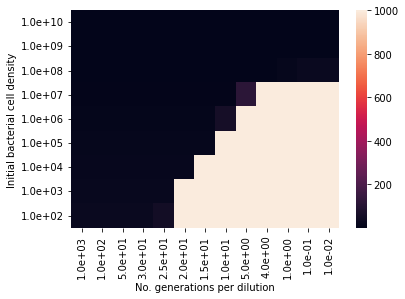

In [22]:
sns.heatmap(data=df,cmap='rocket')
plt.xlabel('No. generations per dilution')  
plt.ylabel('Initial bacterial cell density') 
plt.savefig('data/model/DilutionVSbacterialdensity.pdf', bbox_inches='tight')


In [23]:
df

,1.0e+03,1.0e+02,5.0e+01,3.0e+01,2.5e+01,2.0e+01,1.5e+01,1.0e+01,5.0e+00,4.0e+00,1.0e+00,1.0e-01,1.0e-02
1.0e+10,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1
1.0e+09,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.2,1.2
1.0e+08,4.3,4.3,4.3,4.3,4.3,4.3,4.3,4.3,4.3,4.3,15.7,26.2,26.2
1.0e+07,7.5,7.5,7.5,7.5,7.5,7.5,7.5,7.5,116.1,1000.0,1000.0,1000.0,1000.0
1.0e+06,10.6,10.6,10.6,10.6,10.6,10.6,10.6,57.6,1000.0,1000.0,1000.0,1000.0,1000.0
1.0e+05,14.1,14.1,14.1,14.1,14.1,14.1,14.1,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
1.0e+04,17.8,17.8,17.8,17.8,17.8,17.8,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
1.0e+03,21.4,21.4,21.4,21.4,21.4,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
1.0e+02,25.1,25.1,25.1,25.1,49.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0


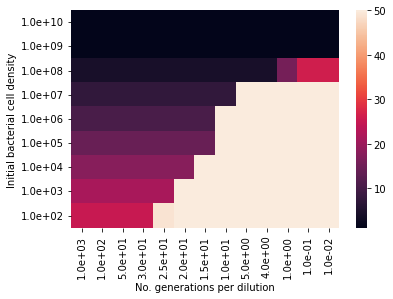

In [24]:
df[df>=50]=50
sns.heatmap(data=df,cmap='rocket')
plt.xlabel('No. generations per dilution')  
plt.ylabel('Initial bacterial cell density') 
plt.savefig('data/model/DilutionVSbacterialdensity2.pdf', bbox_inches='tight')


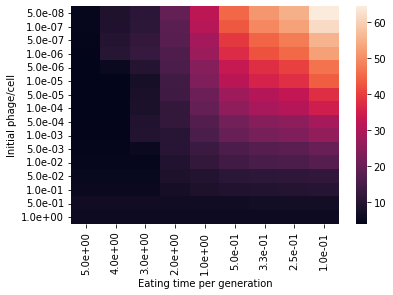

In [17]:
allchangingparameters = {
    'Pnsset':[1e-2,1e-4,1e-6,1e-8,1e-10],
    'detection_limitset':[0.1,0.2,0.5,0.9],
    'time_stepset':[0.01,0.1,0.2,0.5,1],
    'generation_timeset':[0.1,1,2,5,10],
    'K1set' : [np.power(0.1,x) for x in range(1,25)],
    'K2set' : [0.01,0.1,0.5,1,5,10,100,1000],
    'initialCellsPerMlset' :[1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9,1e10],
    'eating_timeset':[5,4,3,2,1,0.5,0.33,0.25,0.1],# * generation_time
    'phagePerCellset' : [x/20000000 for x in range(1,3)]+[x/2000000 for x in range(1,3)]+[x/200000 for x in range(1,3)]+[x/20000 for x in range(1,3)]+[x/2000 for x in range(1,3)]+[x/200 for x in range(1,3)]+[x/20 for x in range(1,3)]+[x/2 for x in range(1,3)]
}

# parameters
phagePerCell = 1e-3
Pns = 1e-8*(1 + 1e-1 + 1e-2 + 1e-3 + 1e-4 + 1e-5) # Exploitation of the Cooperative Behaviors of Anti-CRISPR Phages, cfu per ml = 1e8, read frequency of additional spacers decrease by 1/10
detection_limit = 0.1
time_step = 0.1
generation_time = 1 # 1 day
K1 = 1e-9 # absorption rate, 1e-10 to 1e−9 phage−1 cell−1 ml−1 min−1 for 24h
K2 = 1 #effective phage burst size, [https://www.frontiersin.org/articles/10.3389/fcimb.2021.643214/full CrAssphage 2.5] usually 10-100
initialCellsPerMl = 1e8 # cells per ml of the species of interest
eating_time = 1# eating
celldoubling_per_time_step = np.power(2,time_step) - 1

# others
y_max = 1000*generation_time
df = pd.DataFrame(columns=allchangingparameters['eating_timeset'],
                  index = allchangingparameters['phagePerCellset'],data= 0,dtype = float)
for phagePerCell in df.index:
    for eating_time in df.columns:
        eating_time = eating_time*generation_time
        sweeping_time = currentPim(phagePerCell,Pns,K1,K2,initialCellsPerMl,initialCellsPerMl)
        df.loc[phagePerCell,eating_time] = sweeping_time

df.columns = ['%.1e'%i for i in df.columns]
df.index = ['%.1e'%i for i in df.index]
sns.heatmap(data=df)
plt.xlabel('No. generations per dilution')  
plt.ylabel('Initial phage/cell') 
plt.savefig('data/model/DilutionVSbacterialdensity.pdf', bbox_inches='tight')


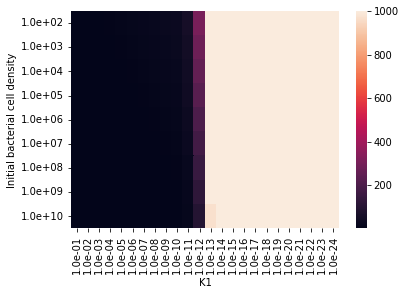

In [107]:
allchangingparameters = {
    'Pnsset':[1e-2,1e-4,1e-6,1e-8,1e-10],
    'detection_limitset':[0.1,0.2,0.5,0.9],
    'time_stepset':[0.01,0.1,0.2,0.5,1],
    'generation_timeset':[0.1,1,2,5,10],
    'K1set' : [np.power(0.1,x) for x in range(1,25)],
    'K2set' : [0.01,0.1,0.5,1,5,10,100,1000],
    'initialCellsPerMlset' :[1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9,1e10],
    'eating_timeset':[5,4,3,2,1,0.5,0.33,0.25,0.1],# * generation_time
    'phagePerCellset' : [x/20000000 for x in range(1,3)]+[x/2000000 for x in range(1,3)]+[x/200000 for x in range(1,3)]+[x/20000 for x in range(1,3)]+[x/2000 for x in range(1,3)]+[x/200 for x in range(1,3)]+[x/20 for x in range(1,3)]+[x/2 for x in range(1,3)]
}

# parameters
phagePerCell = 1e-3
Pns = 1e-8*(1 + 1e-1 + 1e-2 + 1e-3 + 1e-4 + 1e-5) # Exploitation of the Cooperative Behaviors of Anti-CRISPR Phages, cfu per ml = 1e8, read frequency of additional spacers decrease by 1/10
detection_limit = 0.1
time_step = 0.1
generation_time = 1 # 1 day
K1 = 1e-9 # absorption rate, 1e-10 to 1e−9 phage−1 cell−1 ml−1 min−1 for 24h
K2 = 1 #effective phage burst size, [https://www.frontiersin.org/articles/10.3389/fcimb.2021.643214/full CrAssphage 2.5] usually 10-100
initialCellsPerMl = 1e8 # cells per ml of the species of interest
eating_time = 1000# no eat
celldoubling_per_time_step = np.power(2,time_step) - 1

# others
y_max = 1000*generation_time
df = pd.DataFrame(columns=allchangingparameters['K1set'],
                  index = allchangingparameters['initialCellsPerMlset'],data= 0,dtype = float)
for initialCellsPerMl in df.index:
    for K1 in df.columns:
        eating_time = eating_time*generation_time
        sweeping_time = currentPim(phagePerCell,Pns,K1,K2,initialCellsPerMl,initialCellsPerMl)
        df.loc[initialCellsPerMl,K1] = sweeping_time

df.columns = ['%.1e'%i for i in df.columns]
df.index = ['%.1e'%i for i in df.index]
sns.heatmap(data=df)
plt.xlabel('K1')  
plt.ylabel('Initial bacterial cell density') 
plt.savefig('data/model/NodilutionK1VSbacterialdensity.pdf', bbox_inches='tight')


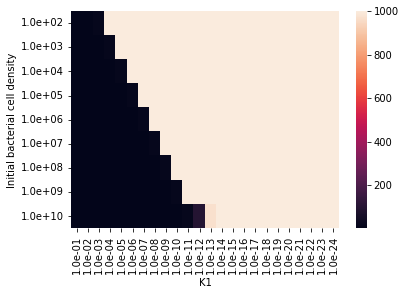

In [108]:
allchangingparameters = {
    'Pnsset':[1e-2,1e-4,1e-6,1e-8,1e-10],
    'detection_limitset':[0.1,0.2,0.5,0.9],
    'time_stepset':[0.01,0.1,0.2,0.5,1],
    'generation_timeset':[0.1,1,2,5,10],
    'K1set' : [np.power(0.1,x) for x in range(1,25)],
    'K2set' : [0.01,0.1,0.5,1,5,10,100,1000],
    'initialCellsPerMlset' :[1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9,1e10],
    'eating_timeset':[5,4,3,2,1,0.5,0.33,0.25,0.1],# * generation_time
    'phagePerCellset' : [x/20000000 for x in range(1,3)]+[x/2000000 for x in range(1,3)]+[x/200000 for x in range(1,3)]+[x/20000 for x in range(1,3)]+[x/2000 for x in range(1,3)]+[x/200 for x in range(1,3)]+[x/20 for x in range(1,3)]+[x/2 for x in range(1,3)]
}

# parameters
phagePerCell = 1e-3
Pns = 1e-8*(1 + 1e-1 + 1e-2 + 1e-3 + 1e-4 + 1e-5) # Exploitation of the Cooperative Behaviors of Anti-CRISPR Phages, cfu per ml = 1e8, read frequency of additional spacers decrease by 1/10
detection_limit = 0.1
time_step = 0.1
generation_time = 1 # 1 day
K1 = 1e-9 # absorption rate, 1e-10 to 1e−9 phage−1 cell−1 ml−1 min−1 for 24h
K2 = 1 #effective phage burst size, [https://www.frontiersin.org/articles/10.3389/fcimb.2021.643214/full CrAssphage 2.5] usually 10-100
initialCellsPerMl = 1e8 # cells per ml of the species of interest
eating_time = 1# eat
celldoubling_per_time_step = np.power(2,time_step) - 1

# others
y_max = 1000*generation_time
df = pd.DataFrame(columns=allchangingparameters['K1set'],
                  index = allchangingparameters['initialCellsPerMlset'],data= 0,dtype = float)
for initialCellsPerMl in df.index:
    for K1 in df.columns:
        eating_time = eating_time*generation_time
        sweeping_time = currentPim(phagePerCell,Pns,K1,K2,initialCellsPerMl,initialCellsPerMl)
        df.loc[initialCellsPerMl,K1] = sweeping_time

df.columns = ['%.1e'%i for i in df.columns]
df.index = ['%.1e'%i for i in df.index]
sns.heatmap(data=df)
plt.xlabel('K1')  
plt.ylabel('Initial bacterial cell density') 
plt.savefig('data/model/DilutionK1VSbacterialdensity.pdf', bbox_inches='tight')


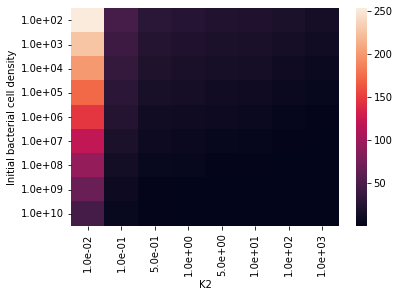

In [109]:
allchangingparameters = {
    'Pnsset':[1e-2,1e-4,1e-6,1e-8,1e-10],
    'detection_limitset':[0.1,0.2,0.5,0.9],
    'time_stepset':[0.01,0.1,0.2,0.5,1],
    'generation_timeset':[0.1,1,2,5,10],
    'K1set' : [np.power(0.1,x) for x in range(1,25)],
    'K2set' : [0.01,0.1,0.5,1,5,10,100,1000],
    'initialCellsPerMlset' :[1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9,1e10],
    'eating_timeset':[5,4,3,2,1,0.5,0.33,0.25,0.1],# * generation_time
    'phagePerCellset' : [x/20000000 for x in range(1,3)]+[x/2000000 for x in range(1,3)]+[x/200000 for x in range(1,3)]+[x/20000 for x in range(1,3)]+[x/2000 for x in range(1,3)]+[x/200 for x in range(1,3)]+[x/20 for x in range(1,3)]+[x/2 for x in range(1,3)]
}

# parameters
phagePerCell = 1e-3
Pns = 1e-8*(1 + 1e-1 + 1e-2 + 1e-3 + 1e-4 + 1e-5) # Exploitation of the Cooperative Behaviors of Anti-CRISPR Phages, cfu per ml = 1e8, read frequency of additional spacers decrease by 1/10
detection_limit = 0.1
time_step = 0.1
generation_time = 1 # 1 day
K1 = 1e-9 # absorption rate, 1e-10 to 1e−9 phage−1 cell−1 ml−1 min−1 for 24h
K2 = 1 #effective phage burst size, [https://www.frontiersin.org/articles/10.3389/fcimb.2021.643214/full CrAssphage 2.5] usually 10-100
initialCellsPerMl = 1e8 # cells per ml of the species of interest
eating_time = 1000# no eat
celldoubling_per_time_step = np.power(2,time_step) - 1

# others
y_max = 1000*generation_time
df = pd.DataFrame(columns=allchangingparameters['K2set'],
                  index = allchangingparameters['initialCellsPerMlset'],data= 0,dtype = float)
for initialCellsPerMl in df.index:
    for K2 in df.columns:
        eating_time = eating_time*generation_time
        sweeping_time = currentPim(phagePerCell,Pns,K1,K2,initialCellsPerMl,initialCellsPerMl)
        df.loc[initialCellsPerMl,K2] = sweeping_time

df.columns = ['%.1e'%i for i in df.columns]
df.index = ['%.1e'%i for i in df.index]
sns.heatmap(data=df)
plt.xlabel('K2')  
plt.ylabel('Initial bacterial cell density') 
plt.savefig('data/model/NoDilutionK2VSbacterialdensity.pdf', bbox_inches='tight')


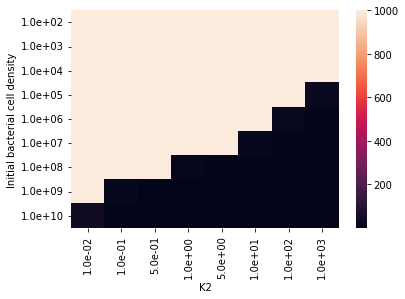

In [110]:
allchangingparameters = {
    'Pnsset':[1e-2,1e-4,1e-6,1e-8,1e-10],
    'detection_limitset':[0.1,0.2,0.5,0.9],
    'time_stepset':[0.01,0.1,0.2,0.5,1],
    'generation_timeset':[0.1,1,2,5,10],
    'K1set' : [np.power(0.1,x) for x in range(1,25)],
    'K2set' : [0.01,0.1,0.5,1,5,10,100,1000],
    'initialCellsPerMlset' :[1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9,1e10],
    'eating_timeset':[5,4,3,2,1,0.5,0.33,0.25,0.1],# * generation_time
    'phagePerCellset' : [x/20000000 for x in range(1,3)]+[x/2000000 for x in range(1,3)]+[x/200000 for x in range(1,3)]+[x/20000 for x in range(1,3)]+[x/2000 for x in range(1,3)]+[x/200 for x in range(1,3)]+[x/20 for x in range(1,3)]+[x/2 for x in range(1,3)]
}

# parameters
phagePerCell = 1e-3
Pns = 1e-8*(1 + 1e-1 + 1e-2 + 1e-3 + 1e-4 + 1e-5) # Exploitation of the Cooperative Behaviors of Anti-CRISPR Phages, cfu per ml = 1e8, read frequency of additional spacers decrease by 1/10
detection_limit = 0.1
time_step = 0.1
generation_time = 1 # 1 day
K1 = 1e-9 # absorption rate, 1e-10 to 1e−9 phage−1 cell−1 ml−1 min−1 for 24h
K2 = 1 #effective phage burst size, [https://www.frontiersin.org/articles/10.3389/fcimb.2021.643214/full CrAssphage 2.5] usually 10-100
initialCellsPerMl = 1e8 # cells per ml of the species of interest
eating_time = 1#  eat
celldoubling_per_time_step = np.power(2,time_step) - 1

# others
y_max = 1000*generation_time
df = pd.DataFrame(columns=allchangingparameters['K2set'],
                  index = allchangingparameters['initialCellsPerMlset'],data= 0,dtype = float)
for initialCellsPerMl in df.index:
    for K2 in df.columns:
        eating_time = eating_time*generation_time
        sweeping_time = currentPim(phagePerCell,Pns,K1,K2,initialCellsPerMl,initialCellsPerMl)
        df.loc[initialCellsPerMl,K2] = sweeping_time

df.columns = ['%.1e'%i for i in df.columns]
df.index = ['%.1e'%i for i in df.index]
sns.heatmap(data=df)
plt.xlabel('K2')  
plt.ylabel('Initial bacterial cell density') 
plt.savefig('data/model/DilutionK2VSbacterialdensity.pdf', bbox_inches='tight')


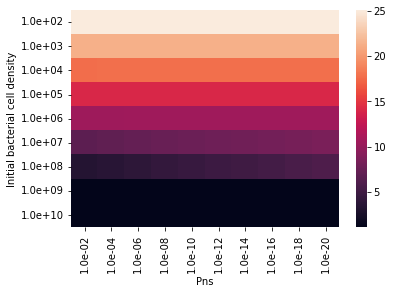

In [111]:
allchangingparameters = {
    'Pnsset':[1e-2,1e-4,1e-6,1e-8,1e-10,1e-12,1e-14,1e-16,1e-18,1e-20],
    'detection_limitset':[0.1,0.2,0.5,0.9],
    'time_stepset':[0.01,0.1,0.2,0.5,1],
    'generation_timeset':[0.1,1,2,5,10],
    'K1set' : [np.power(0.1,x) for x in range(1,25)],
    'K2set' : [0.01,0.1,0.5,1,5,10,100,1000],
    'initialCellsPerMlset' :[1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9,1e10],
    'eating_timeset':[5,4,3,2,1,0.5,0.33,0.25,0.1],# * generation_time
    'phagePerCellset' : [x/20000000 for x in range(1,3)]+[x/2000000 for x in range(1,3)]+[x/200000 for x in range(1,3)]+[x/20000 for x in range(1,3)]+[x/2000 for x in range(1,3)]+[x/200 for x in range(1,3)]+[x/20 for x in range(1,3)]+[x/2 for x in range(1,3)]
}

# parameters
phagePerCell = 1e-3
Pns = 1e-8*(1 + 1e-1 + 1e-2 + 1e-3 + 1e-4 + 1e-5) # Exploitation of the Cooperative Behaviors of Anti-CRISPR Phages, cfu per ml = 1e8, read frequency of additional spacers decrease by 1/10
detection_limit = 0.1
time_step = 0.1
generation_time = 1 # 1 day
K1 = 1e-9 # absorption rate, 1e-10 to 1e−9 phage−1 cell−1 ml−1 min−1 for 24h
K2 = 1 #effective phage burst size, [https://www.frontiersin.org/articles/10.3389/fcimb.2021.643214/full CrAssphage 2.5] usually 10-100
initialCellsPerMl = 1e8 # cells per ml of the species of interest
eating_time = 1000# no eat
celldoubling_per_time_step = np.power(2,time_step) - 1

# others
y_max = 1000*generation_time
df = pd.DataFrame(columns=allchangingparameters['Pnsset'],
                  index = allchangingparameters['initialCellsPerMlset'],data= 0,dtype = float)
for initialCellsPerMl in df.index:
    for Pns in df.columns:
        eating_time = eating_time*generation_time
        sweeping_time = currentPim(phagePerCell,Pns,K1,K2,initialCellsPerMl,initialCellsPerMl)
        df.loc[initialCellsPerMl,Pns] = sweeping_time

df.columns = ['%.1e'%i for i in df.columns]
df.index = ['%.1e'%i for i in df.index]
sns.heatmap(data=df)
plt.xlabel('Pns')  
plt.ylabel('Initial bacterial cell density') 
plt.savefig('data/model/NodilutionPnsVSbacterialdensity.pdf', bbox_inches='tight')


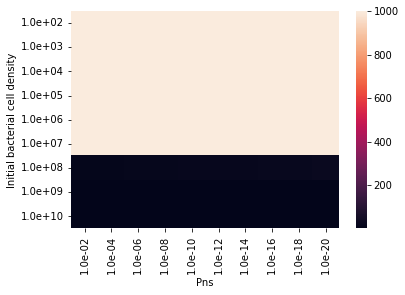

In [112]:
allchangingparameters = {
    'Pnsset':[1e-2,1e-4,1e-6,1e-8,1e-10,1e-12,1e-14,1e-16,1e-18,1e-20],
    'detection_limitset':[0.1,0.2,0.5,0.9],
    'time_stepset':[0.01,0.1,0.2,0.5,1],
    'generation_timeset':[0.1,1,2,5,10],
    'K1set' : [np.power(0.1,x) for x in range(1,25)],
    'K2set' : [0.01,0.1,0.5,1,5,10,100,1000],
    'initialCellsPerMlset' :[1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9,1e10],
    'eating_timeset':[5,4,3,2,1,0.5,0.33,0.25,0.1],# * generation_time
    'phagePerCellset' : [x/20000000 for x in range(1,3)]+[x/2000000 for x in range(1,3)]+[x/200000 for x in range(1,3)]+[x/20000 for x in range(1,3)]+[x/2000 for x in range(1,3)]+[x/200 for x in range(1,3)]+[x/20 for x in range(1,3)]+[x/2 for x in range(1,3)]
}

# parameters
phagePerCell = 1e-3
Pns = 1e-8*(1 + 1e-1 + 1e-2 + 1e-3 + 1e-4 + 1e-5) # Exploitation of the Cooperative Behaviors of Anti-CRISPR Phages, cfu per ml = 1e8, read frequency of additional spacers decrease by 1/10
detection_limit = 0.1
time_step = 0.1
generation_time = 1 # 1 day
K1 = 1e-9 # absorption rate, 1e-10 to 1e−9 phage−1 cell−1 ml−1 min−1 for 24h
K2 = 1 #effective phage burst size, [https://www.frontiersin.org/articles/10.3389/fcimb.2021.643214/full CrAssphage 2.5] usually 10-100
initialCellsPerMl = 1e8 # cells per ml of the species of interest
eating_time = 1# no eat
celldoubling_per_time_step = np.power(2,time_step) - 1

# others
y_max = 1000*generation_time
df = pd.DataFrame(columns=allchangingparameters['Pnsset'],
                  index = allchangingparameters['initialCellsPerMlset'],data= 0,dtype = float)
for initialCellsPerMl in df.index:
    for Pns in df.columns:
        eating_time = eating_time*generation_time
        sweeping_time = currentPim(phagePerCell,Pns,K1,K2,initialCellsPerMl,initialCellsPerMl)
        df.loc[initialCellsPerMl,Pns] = sweeping_time

df.columns = ['%.1e'%i for i in df.columns]
df.index = ['%.1e'%i for i in df.index]
sns.heatmap(data=df)
plt.xlabel('Pns')  
plt.ylabel('Initial bacterial cell density') 
plt.savefig('data/model/DilutionPnsVSbacterialdensity.pdf', bbox_inches='tight')


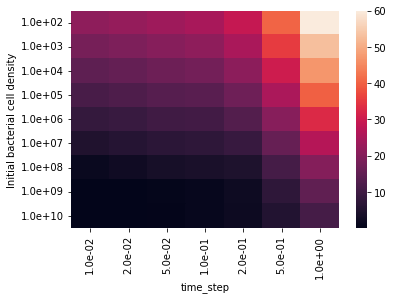

In [7]:
allchangingparameters = {
    'Pnsset':[1e-2,1e-4,1e-6,1e-8,1e-10,1e-12,1e-14,1e-16,1e-18,1e-20],
    'detection_limitset':[0.1,0.2,0.5,0.9],
    'time_stepset':[0.01,0.02,0.05,0.1,0.2,0.5,1],
    'generation_timeset':[0.1,1,2,5,10],
    'K1set' : [np.power(0.1,x) for x in range(1,25)],
    'K2set' : [0.01,0.1,0.5,1,5,10,100,1000],
    'initialCellsPerMlset' :[1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9,1e10],
    'eating_timeset':[5,4,3,2,1,0.5,0.33,0.25,0.1],# * generation_time
    'phagePerCellset' : [x/20000000 for x in range(1,3)]+[x/2000000 for x in range(1,3)]+[x/200000 for x in range(1,3)]+[x/20000 for x in range(1,3)]+[x/2000 for x in range(1,3)]+[x/200 for x in range(1,3)]+[x/20 for x in range(1,3)]+[x/2 for x in range(1,3)]
}

# parameters
phagePerCell = 1e-3
Pns = 1e-8*(1 + 1e-1 + 1e-2 + 1e-3 + 1e-4 + 1e-5) # Exploitation of the Cooperative Behaviors of Anti-CRISPR Phages, cfu per ml = 1e8, read frequency of additional spacers decrease by 1/10
detection_limit = 0.1
time_step = 0.1
generation_time = 1 # 1 day
K1 = 1e-9 # absorption rate, 1e-10 to 1e−9 phage−1 cell−1 ml−1 min−1 for 24h
K2 = 1 #effective phage burst size, [https://www.frontiersin.org/articles/10.3389/fcimb.2021.643214/full CrAssphage 2.5] usually 10-100
initialCellsPerMl = 1e8 # cells per ml of the species of interest
eating_time = 1000# no eat

# others
y_max = 1000*generation_time
df = pd.DataFrame(columns=allchangingparameters['time_stepset'],
                  index = allchangingparameters['initialCellsPerMlset'],data= 0,dtype = float)
for initialCellsPerMl in df.index:
    for time_step in df.columns:
        celldoubling_per_time_step = np.power(2,time_step) - 1
        eating_time = eating_time*generation_time
        sweeping_time = currentPim(phagePerCell,Pns,K1,K2,initialCellsPerMl,initialCellsPerMl)
        df.loc[initialCellsPerMl,time_step] = sweeping_time

df.columns = ['%.1e'%i for i in df.columns]
df.index = ['%.1e'%i for i in df.index]
sns.heatmap(data=df)
plt.xlabel('Time step')  
plt.ylabel('Initial bacterial cell density') 
plt.savefig('data/model/Nodilutiontime_stepVSbacterialdensity.pdf', bbox_inches='tight')


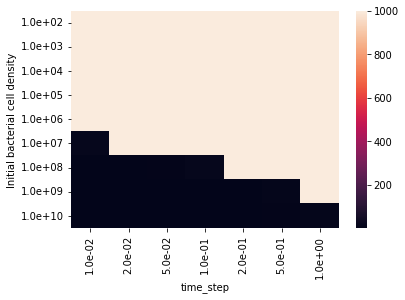

In [10]:
allchangingparameters = {
    'Pnsset':[1e-2,1e-4,1e-6,1e-8,1e-10,1e-12,1e-14,1e-16,1e-18,1e-20],
    'detection_limitset':[0.1,0.2,0.5,0.9],
    'time_stepset':[0.01,0.02,0.05,0.1,0.2,0.5,1],
    'generation_timeset':[0.1,1,2,5,10],
    'K1set' : [np.power(0.1,x) for x in range(1,25)],
    'K2set' : [0.01,0.1,0.5,1,5,10,100,1000],
    'initialCellsPerMlset' :[1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9,1e10],
    'eating_timeset':[5,4,3,2,1,0.5,0.33,0.25,0.1],# * generation_time
    'phagePerCellset' : [x/20000000 for x in range(1,3)]+[x/2000000 for x in range(1,3)]+[x/200000 for x in range(1,3)]+[x/20000 for x in range(1,3)]+[x/2000 for x in range(1,3)]+[x/200 for x in range(1,3)]+[x/20 for x in range(1,3)]+[x/2 for x in range(1,3)]
}

# parameters
phagePerCell = 1e-3
Pns = 1e-8*(1 + 1e-1 + 1e-2 + 1e-3 + 1e-4 + 1e-5) # Exploitation of the Cooperative Behaviors of Anti-CRISPR Phages, cfu per ml = 1e8, read frequency of additional spacers decrease by 1/10
detection_limit = 0.1
time_step = 0.1
generation_time = 1 # 1 day
K1 = 1e-9 # absorption rate, 1e-10 to 1e−9 phage−1 cell−1 ml−1 min−1 for 24h
K2 = 1 #effective phage burst size, [https://www.frontiersin.org/articles/10.3389/fcimb.2021.643214/full CrAssphage 2.5] usually 10-100
initialCellsPerMl = 1e8 # cells per ml of the species of interest
eating_time = 1# Eat

# others
y_max = 1000*generation_time
df = pd.DataFrame(columns=allchangingparameters['time_stepset'],
                  index = allchangingparameters['initialCellsPerMlset'],data= 0,dtype = float)
for initialCellsPerMl in df.index:
    for time_step in df.columns:
        celldoubling_per_time_step = np.power(2,time_step) - 1
        eating_time = eating_time*generation_time
        sweeping_time = currentPim(phagePerCell,Pns,K1,K2,initialCellsPerMl,initialCellsPerMl)
        df.loc[initialCellsPerMl,time_step] = sweeping_time

df.columns = ['%.1e'%i for i in df.columns]
df.index = ['%.1e'%i for i in df.index]
sns.heatmap(data=df)
plt.xlabel('time_step')  
plt.ylabel('Initial bacterial cell density') 
plt.savefig('data/model/Dilutiontime_stepVSbacterialdensity.pdf', bbox_inches='tight')


In [ ]:
allchangingparameters = {
    'Pnsset':[1e-2,1e-4,1e-6,1e-8,1e-10,1e-12,1e-14,1e-16,1e-18,1e-20],
    'detection_limitset':[0.1,0.2,0.5,0.9],
    'time_stepset':[0.01,0.02,0.05,0.1,0.2,0.5,1],
    'generation_timeset':[0.1,1,2,5,10],
    'K1set' : [np.power(0.1,x) for x in range(1,25)],
    'K2set' : [0.01,0.1,0.5,1,5,10,100,1000],
    'initialCellsPerMlset' :[1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9,1e10],
    'eating_timeset':[5,4,3,2,1,0.5,0.33,0.25,0.1],# * generation_time
    'phagePerCellset' : [x/20000000 for x in range(1,3)]+[x/2000000 for x in range(1,3)]+[x/200000 for x in range(1,3)]+[x/20000 for x in range(1,3)]+[x/2000 for x in range(1,3)]+[x/200 for x in range(1,3)]+[x/20 for x in range(1,3)]+[x/2 for x in range(1,3)]
}

# parameters
phagePerCell = 1e-3
Pns = 1e-8*(1 + 1e-1 + 1e-2 + 1e-3 + 1e-4 + 1e-5) # Exploitation of the Cooperative Behaviors of Anti-CRISPR Phages, cfu per ml = 1e8, read frequency of additional spacers decrease by 1/10
detection_limit = 0.1
time_step = 0.1
generation_time = 1 # 1 day
K1 = 1e-9 # absorption rate, 1e-10 to 1e−9 phage−1 cell−1 ml−1 min−1 for 24h
K2 = 1 #effective phage burst size, [https://www.frontiersin.org/articles/10.3389/fcimb.2021.643214/full CrAssphage 2.5] usually 10-100
initialCellsPerMl = 1e8 # cells per ml of the species of interest
eating_time = 1# Eat

# others
y_max = 1000*generation_time
df = pd.DataFrame(columns=allchangingparameters['time_stepset'],
                  index = allchangingparameters['initialCellsPerMlset'],data= 0,dtype = float)
for initialCellsPerMl in df.index:
    for time_step in df.columns:
        celldoubling_per_time_step = np.power(2,time_step) - 1
        eating_time = eating_time*generation_time
        sweeping_time = currentPim(phagePerCell,Pns,K1,K2,initialCellsPerMl,initialCellsPerMl)
        df.loc[initialCellsPerMl,time_step] = sweeping_time

df.columns = ['%.1e'%i for i in df.columns]
df.index = ['%.1e'%i for i in df.index]
sns.heatmap(data=df)
plt.xlabel('time_step')  
plt.ylabel('Initial bacterial cell density') 
plt.savefig('data/model/Dilutiontime_stepVSbacterialdensity.pdf', bbox_inches='tight')


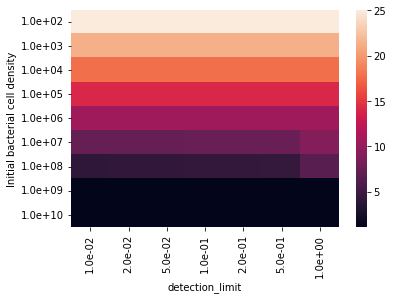

In [12]:
allchangingparameters = {
    'Pnsset':[1e-2,1e-4,1e-6,1e-8,1e-10,1e-12,1e-14,1e-16,1e-18,1e-20],
    'detection_limitset':[0.1,0.2,0.5,0.9],
    'time_stepset':[0.01,0.02,0.05,0.1,0.2,0.5,1],
    'generation_timeset':[0.1,1,2,5,10],
    'K1set' : [np.power(0.1,x) for x in range(1,25)],
    'K2set' : [0.01,0.1,0.5,1,5,10,100,1000],
    'initialCellsPerMlset' :[1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9,1e10],
    'eating_timeset':[5,4,3,2,1,0.5,0.33,0.25,0.1],# * generation_time
    'phagePerCellset' : [x/20000000 for x in range(1,3)]+[x/2000000 for x in range(1,3)]+[x/200000 for x in range(1,3)]+[x/20000 for x in range(1,3)]+[x/2000 for x in range(1,3)]+[x/200 for x in range(1,3)]+[x/20 for x in range(1,3)]+[x/2 for x in range(1,3)]
}

# parameters
phagePerCell = 1e-3
Pns = 1e-8*(1 + 1e-1 + 1e-2 + 1e-3 + 1e-4 + 1e-5) # Exploitation of the Cooperative Behaviors of Anti-CRISPR Phages, cfu per ml = 1e8, read frequency of additional spacers decrease by 1/10
detection_limit = 0.1
time_step = 0.1
generation_time = 1 # 1 day
K1 = 1e-9 # absorption rate, 1e-10 to 1e−9 phage−1 cell−1 ml−1 min−1 for 24h
K2 = 1 #effective phage burst size, [https://www.frontiersin.org/articles/10.3389/fcimb.2021.643214/full CrAssphage 2.5] usually 10-100
initialCellsPerMl = 1e8 # cells per ml of the species of interest
eating_time = 1000# Eat

# others
y_max = 1000*generation_time
df = pd.DataFrame(columns=allchangingparameters['time_stepset'],
                  index = allchangingparameters['initialCellsPerMlset'],data= 0,dtype = float)
for initialCellsPerMl in df.index:
    for detection_limit in df.columns:
        celldoubling_per_time_step = np.power(2,time_step) - 1
        eating_time = eating_time*generation_time
        sweeping_time = currentPim(phagePerCell,Pns,K1,K2,initialCellsPerMl,initialCellsPerMl)
        df.loc[initialCellsPerMl,detection_limit] = sweeping_time

df.columns = ['%.1e'%i for i in df.columns]
df.index = ['%.1e'%i for i in df.index]
sns.heatmap(data=df)
plt.xlabel('detection_limit')  
plt.ylabel('Initial bacterial cell density') 
plt.savefig('data/model/Nodilutiondetection_limitVSbacterialdensity.pdf', bbox_inches='tight')
